In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize 
import sys
sys.path.append('../utils')

from UCB1_constrained import UCBLikeAgent 
from Thompson_constrained import ThompsonLikeAgent

# Environment Setup

In [2]:
class StochasticPricingEnvironment:
    """
    Stochastic environment for dynamic pricing with customer valuation uncertainty.
    
    This environment simulates a single-product pricing scenario where:
    - Customers have valuations drawn from a known distribution
    - The probability of purchase depends on whether customer valuation >= price
    - Each round represents one customer interaction
    """
    def __init__(self, valuation_distribution):
        """
        Initialize the pricing environment.
        
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
        """
        self.valuation_dist = valuation_distribution
        
    def demand_probability(self, price):
        """
        Calculate the theoretical probability that a customer purchases at given price.
        
        This is the complement of the CDF: P(valuation >= price) = 1 - F(price)
        where F is the cumulative distribution function of customer valuations.
        
        Args:
            price: The price to evaluate
            
        Returns:
            Probability that a randomly drawn customer will purchase at this price
        """
        return 1 - self.valuation_dist.cdf(price)

    def simulate_round(self, price):
        """
        Simulate one customer interaction at the given price.
        
        Args:
            price: The price offered to the customer
            
        Returns:
            tuple: (sale_made, revenue) where:
                - sale_made: 1 if customer purchased, 0 otherwise
                - revenue: price if sale was made, 0 otherwise
        """
        # Draw a random customer valuation from the distribution
        valuation = self.valuation_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        return sale_made, revenue

# Theoretical Optimal


In [3]:
#define the optimal solution
def compute_clairvoyant(prices, environment, T, P):
    """
    Compute the optimal (clairvoyant) pricing strategy with full information.
    
    This function solves the linear program that an oracle with perfect knowledge
    of the demand probabilities would solve:
    
    maximize: sum_i gamma_i * price_i * demand_prob_i
    subject to: sum_i gamma_i * demand_prob_i <= P/T  (inventory constraint)
               sum_i gamma_i = 1                      (probability constraint)
               gamma_i >= 0                          (non-negativity)
    
    Args:
        prices: List of available prices
        environment: StochasticPricingEnvironment to get true demand probabilities
        T: Time horizon
        P: Total inventory
        
    Returns:
        tuple: (optimal_distribution, optimal_value, demand_probabilities, expected_revenues)
    """
    # Compute true demand probabilities for each price
    buying_probabilities = np.array([environment.demand_probability(p) for p in prices])
    
    # Expected revenue per selection for each price
    exp_reward= prices * buying_probabilities
    
    # Set up linear program (convert maximization to minimization)
    c = -exp_reward  # Negate for minimization
    
    # Inventory constraint: expected consumption rate <= inventory rate
    A_ub = [buying_probabilities]
    b_ub = [P / T]
    
    # Probability constraint: sum of probabilities = 1
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    # Solve the linear program
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,method='highs', 
                          bounds=[(0, 1) for _ in range(len(prices))])
    
    gamma = res.x  # Optimal price distribution
    optimal_value = -(res.fun)  # Optimal expected revenue per round
    
    return gamma, optimal_value, buying_probabilities, exp_reward

# Simulation

In [4]:
def run_comparison_simulator(
    T,
    valuation_dist,
    env_config,
    ucb_params,
    thompson_params,
    n_simulations=1,
    verbose=True,
    seed=None
):
    """
    Run simulation comparing UCB and Thompson agents.
    
    Returns results for both agents to enable comparison.
    Ensures both agents face the same sequence of customer valuations.
    """
    
    # Set seed if provided
    if seed is not None:
        np.random.seed(seed)
    
    # === Compute theoretical optimum once before all simulations ===
    env_theoretical = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )
    # Use UCB params for theoretical optimum (should be same as Thompson params)
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=ucb_params['prices'],
        environment=env_theoretical,
        T=ucb_params['T'],
        P=ucb_params['P']
    )
    optimal_idx = np.argmax(opt_dist)
    optimal_revenue = opt_value
    
    # Pre-generate the sequence of customer valuations for fair comparison
    print("Pre-generating customer valuations for fair comparison...")
    if seed is not None:
        np.random.seed(seed + 1000)  # Use offset seed for valuation generation
    
    customer_valuations = valuation_dist.rvs(size=T)
    
    # Results storage for both agents
    results = {
        'UCB': {
            'selected_prices': [],
            'revenues': [],
            'sales': [],
            'cumulative_revenue': [],
            'total_revenue': 0,
            'best_prices': [],
            'first_inventory_empty': None,
            'price_counts': None,
            'agent': None
        },
        'Thompson': {
            'selected_prices': [],
            'revenues': [],
            'sales': [],
            'cumulative_revenue': [],
            'total_revenue': 0,
            'best_prices': [],
            'first_inventory_empty': None,
            'price_counts': None,
            'agent': None
        }
    }
    
    agent_configs = {
        'UCB': ucb_params,
        'Thompson': thompson_params
    }
    
    for agent_type in ['UCB', 'Thompson']:
        print(f"\n=== Running {agent_type} Pricing Simulation for {T} rounds ===")
        
        # Set agent-specific seed for deterministic behavior
        if seed is not None:
            agent_seed = seed + (100 if agent_type == 'UCB' else 200)
            np.random.seed(agent_seed)
        
        for sim in range(n_simulations):
            # Initialize variables for this simulation
            selected_prices = []
            revenues = []
            sales = []
            cumulative_revenue = []
            total_revenue = 0
            best_prices = []
            first_inventory_empty = None
            
            # Create agent (environment will use pre-generated valuations)
            if agent_type == 'UCB':
                agent = UCBLikeAgent(**ucb_params)
            else:  # Thompson
                agent = ThompsonLikeAgent(**thompson_params)

            for t in range(T):
                if agent.remaining_inventory < 1 and first_inventory_empty is None:
                    first_inventory_empty = t
                    if verbose:
                        print(f"Inventory empty for the first time at round {t}")

                price = agent.select_price()
                price_idx = agent.current_price_idx

                if agent.remaining_inventory <= 0:
                    sale_made = False
                    revenue = 0
                else:
                    # Use pre-generated valuation for this round
                    valuation = customer_valuations[t]
                    
                    # Customer purchases if their valuation >= price
                    sale_made = 1 if valuation >= price else 0
                    
                    # Revenue is price if sale was made, 0 otherwise
                    revenue = sale_made * price

                agent.update(revenue, sale_made)

                selected_prices.append(price)
                revenues.append(revenue)
                sales.append(sale_made)
                total_revenue += revenue
                cumulative_revenue.append(total_revenue)
                
                # Print progress occasionally
                if verbose and (t + 1) % (T // 5) == 0:
                    remaining_inventory = agent.remaining_inventory
                    print(f"Round {t + 1:4d}: Revenue = {revenue:6.2f}, "
                        f"Cumulative = {total_revenue:8.2f}, "
                        f"Remaining inventory = {remaining_inventory:.0f}")

            best_price, best_avg_revenue = agent.get_best_price()
            best_prices.append(best_price)

            if verbose:
                print(f"\n{agent_type} Simulation completed!")
                print(f"Total revenue: {total_revenue:.2f}")
                print(f"Average revenue per round: {total_revenue / T:.2f}")
                print(f"Agent's best price: {best_price} (avg revenue: {best_avg_revenue:.2f})")

            # Store results for this agent
            results[agent_type]['selected_prices'] = selected_prices
            results[agent_type]['revenues'] = revenues
            results[agent_type]['sales'] = sales
            results[agent_type]['cumulative_revenue'] = cumulative_revenue
            results[agent_type]['total_revenue'] = total_revenue
            results[agent_type]['best_prices'] = best_prices
            results[agent_type]['first_inventory_empty'] = first_inventory_empty
            results[agent_type]['agent'] = agent

        # Calculate price counts using the correct params for this agent
        current_params = agent_configs[agent_type]
        price_to_idx = {p: i for i, p in enumerate(current_params['prices'])}
        price_indices = [price_to_idx[p] for p in results[agent_type]['selected_prices'] if not np.isnan(p)]
        price_counts = np.bincount(price_indices, minlength=len(current_params['prices']))
        results[agent_type]['price_counts'] = price_counts

        if verbose:
            print(f"\n=== {agent_type} Results ===")
            print("Price selection frequency:")
            for i, (price, count) in enumerate(zip(current_params['prices'], price_counts)):
                percentage = 100 * count / T
                marker = " ← OPTIMAL" if i == optimal_idx else ""
                print(f"  Price {price:.2f}: {count:4d} times ({percentage:5.1f}%){marker}")

    # Add common results
    results['opt_dist'] = opt_dist
    results['optimal_idx'] = optimal_idx
    results['optimal_revenue'] = optimal_revenue
    results['ucb_params'] = ucb_params
    results['thompson_params'] = thompson_params
    results['customer_valuations'] = customer_valuations  # Store for reference
    
    return results


# Plot the results

In [5]:
budget = 0.8
T=10000

In [6]:
# Environment Configuration
env_config = {
    'valuation_mean': 0.5,  # Average customer valuation
    'valuation_std': 0.1,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

inventory = T*budget # Inventory constraint
n_prices = 7

# Common parameters for both agents
common_params = {
    'P': inventory,  # inventory constraint
    'T': T,  # number of rounds
    'prices': np.linspace(0.1, 0.9, n_prices),  # set of prices 
}

# UCB-specific parameters
ucb_params = {
    **common_params,
    'confidence_bound': 1,  # UCB exploration parameter
    'rho_penalty': 1,  # Penalty factor for inventory constraint
    'use_pen_rho': False  # Use rho penalty for inventory constraint
}

# Thompson-specific parameters
thompson_params = {
    **common_params,
    'alpha_prior': 1.0,  # Prior alpha parameter for Beta distribution
    'beta_prior': 1.0    # Prior beta parameter for Beta distribution
}

print(f"Number of price options: {len(common_params['prices'])}")
print(f"UCB confidence bound: {ucb_params['confidence_bound']}")
print(f'Inventory constraint: {common_params["P"]}')
print(f'Number of rounds: {common_params["T"]}')
print(f'Budget: {budget*100}%')

# Run comparison simulation with fixed seed for reproducibility
results = run_comparison_simulator(
    T=T,
    valuation_dist=valuation_dist,
    env_config=env_config,
    ucb_params=ucb_params,
    thompson_params=thompson_params,
    n_simulations=1,
    verbose=True,
    seed=42  # Fixed seed for fair comparison
)

print(f"\n=== COMPARISON SUMMARY ===")
print(f"UCB Total Revenue: {results['UCB']['total_revenue']:.2f}")
print(f"Thompson Total Revenue: {results['Thompson']['total_revenue']:.2f}")
print(f"Optimal Revenue: {results['optimal_revenue'] * T:.2f}")
print(f"UCB Performance: {results['UCB']['total_revenue'] / (results['optimal_revenue'] * T) * 100:.1f}%")
print(f"Thompson Performance: {results['Thompson']['total_revenue'] / (results['optimal_revenue'] * T) * 100:.1f}%")

# Verify that both agents faced the same customer sequence
print(f"\n=== FAIRNESS VERIFICATION ===")
print(f"Customer valuations sequence length: {len(results['customer_valuations'])}")
print(f"Sample valuations (first 10): {results['customer_valuations'][:10]}")
print("✓ Both agents faced the same sequence of customer valuations")

Number of price options: 7
UCB confidence bound: 1
Inventory constraint: 8000.0
Number of rounds: 10000
Budget: 80.0%
Pre-generating customer valuations for fair comparison...

=== Running UCB Pricing Simulation for 10000 rounds ===
Round 2000: Revenue =   0.37, Cumulative =   500.77, Remaining inventory = 6511
Round 2000: Revenue =   0.37, Cumulative =   500.77, Remaining inventory = 6511
Round 4000: Revenue =   0.00, Cumulative =  1079.07, Remaining inventory = 4872
Round 4000: Revenue =   0.00, Cumulative =  1079.07, Remaining inventory = 4872
Round 6000: Revenue =   0.37, Cumulative =  1696.20, Remaining inventory = 3150
Round 6000: Revenue =   0.37, Cumulative =  1696.20, Remaining inventory = 3150
Round 8000: Revenue =   0.37, Cumulative =  2303.97, Remaining inventory = 1475
Round 8000: Revenue =   0.37, Cumulative =  2303.97, Remaining inventory = 1475
Inventory empty for the first time at round 9995
Round 10000: Revenue =   0.00, Cumulative =  2878.00, Remaining inventory = 0


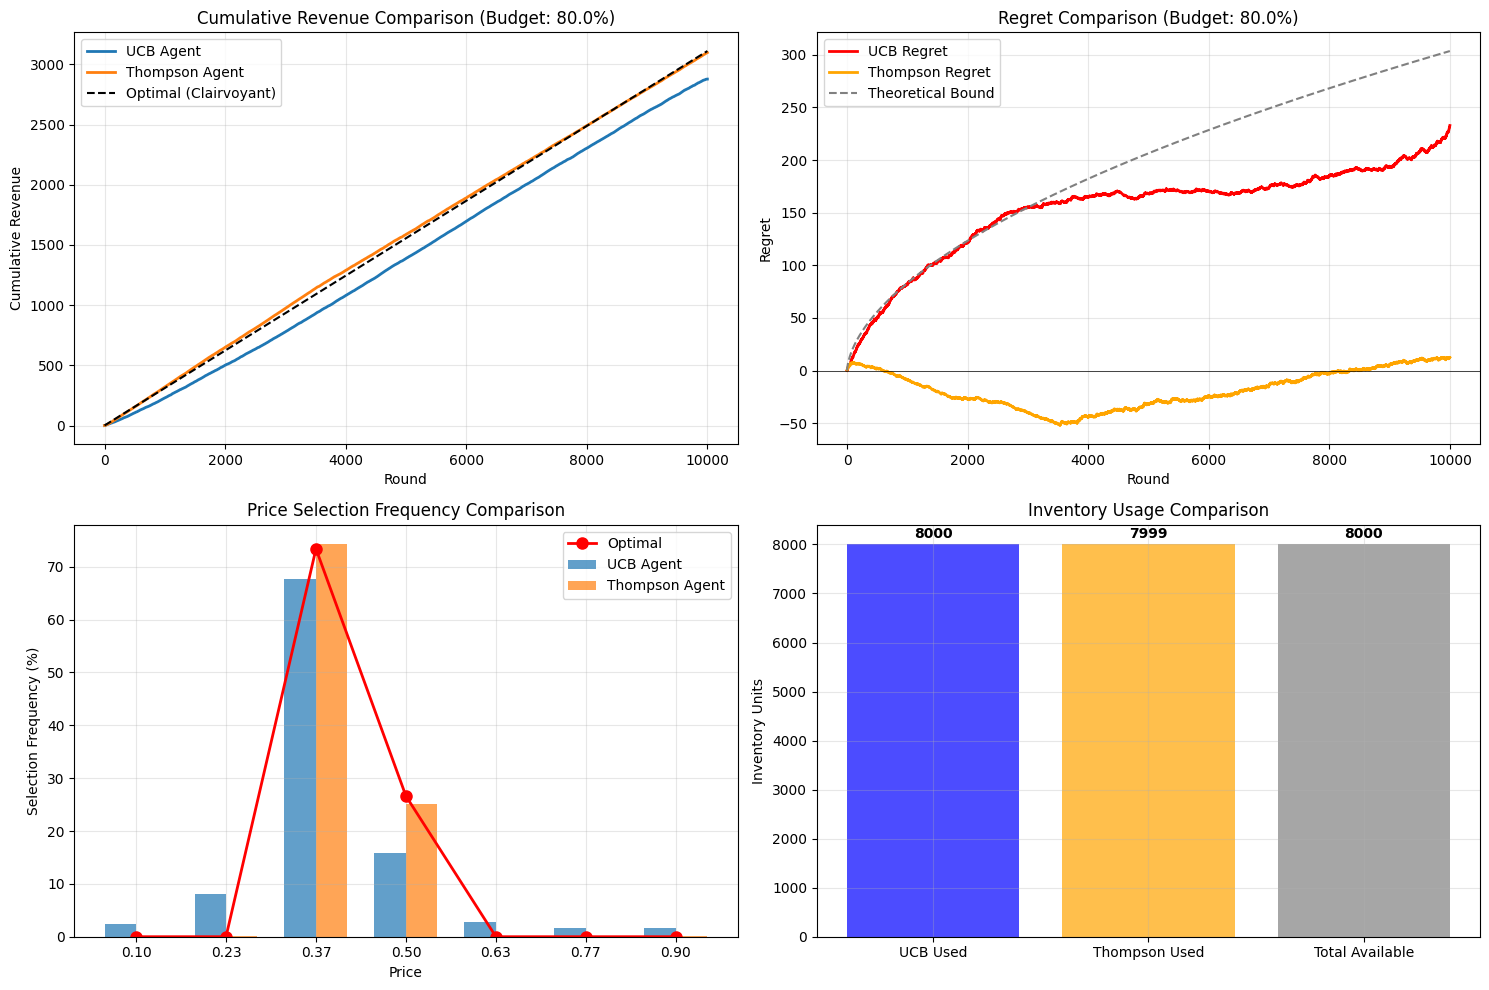


=== DETAILED PERFORMANCE COMPARISON ===
Metric                    UCB          Thompson     Optimal     
-----------------------------------------------------------------
Total Revenue             2878.00      3098.17      3110.75     
Final Regret              232.75       12.58        0.00        
Inventory Used            8000         7999         8000        
Inventory Utilization     100.0       % 100.0       % 100.0       %

🏆 Winner: Thompson Agent (by 220.17 revenue units)


In [7]:
# Compute baseline for regret calculation
_, opt_value, _, _ = compute_clairvoyant(
    prices=results['ucb_params']['prices'],
    environment=StochasticPricingEnvironment(valuation_distribution=valuation_dist),
    T=results['ucb_params']['T'],
    P=results['ucb_params']['P']
)

baseline_reward = [opt_value * (t + 1) for t in range(T)]

# Calculate regret for both agents
regret_ucb = np.array(baseline_reward) - results['UCB']['cumulative_revenue']
regret_thompson = np.array(baseline_reward) - results['Thompson']['cumulative_revenue']

t_vals = np.arange(1, T + 1)
theoretical_bound = np.sqrt(np.log(t_vals) * t_vals)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Cumulative Revenue Comparison
axes[0, 0].plot(results['UCB']['cumulative_revenue'], label="UCB Agent", linewidth=2)
axes[0, 0].plot(results['Thompson']['cumulative_revenue'], label="Thompson Agent", linewidth=2)
axes[0, 0].plot(baseline_reward, label="Optimal (Clairvoyant)", linestyle="--", color='black')
axes[0, 0].set_xlabel("Round")
axes[0, 0].set_ylabel("Cumulative Revenue")
axes[0, 0].set_title(f"Cumulative Revenue Comparison (Budget: {budget*100}%)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Regret Comparison
axes[0, 1].plot(regret_ucb, label="UCB Regret", color='red', linewidth=2)
axes[0, 1].plot(regret_thompson, label="Thompson Regret", color='orange', linewidth=2)
axes[0, 1].plot(theoretical_bound, label="Theoretical Bound", linestyle="--", color='gray')
axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].set_xlabel("Round")
axes[0, 1].set_ylabel("Regret")
axes[0, 1].set_title(f"Regret Comparison (Budget: {budget*100}%)")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Price Selection Frequency Comparison
price_labels = [f"{p:.2f}" for p in results['ucb_params']['prices']]
x_pos = np.arange(len(price_labels))
width = 0.35

ucb_frequencies = results['UCB']['price_counts'] / T * 100
thompson_frequencies = results['Thompson']['price_counts'] / T * 100
optimal_frequencies = results['opt_dist'] * 100

axes[1, 0].bar(x_pos - width/2, ucb_frequencies, width, label='UCB Agent', alpha=0.7)
axes[1, 0].bar(x_pos + width/2, thompson_frequencies, width, label='Thompson Agent', alpha=0.7)
axes[1, 0].plot(x_pos, optimal_frequencies, 'ro-', label='Optimal', linewidth=2, markersize=8)
axes[1, 0].set_xlabel("Price")
axes[1, 0].set_ylabel("Selection Frequency (%)")
axes[1, 0].set_title("Price Selection Frequency Comparison")
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(price_labels)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Inventory Usage Comparison
ucb_inventory_used = results['ucb_params']['P'] - results['UCB']['agent'].remaining_inventory
thompson_inventory_used = results['thompson_params']['P'] - results['Thompson']['agent'].remaining_inventory

inventory_data = [
    ucb_inventory_used,
    thompson_inventory_used,
    results['ucb_params']['P']
]
inventory_labels = ['UCB Used', 'Thompson Used', 'Total Available']
colors = ['blue', 'orange', 'gray']

bars = axes[1, 1].bar(inventory_labels, inventory_data, color=colors, alpha=0.7)
axes[1, 1].set_ylabel("Inventory Units")
axes[1, 1].set_title("Inventory Usage Comparison")
axes[1, 1].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, inventory_data):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\n=== DETAILED PERFORMANCE COMPARISON ===")
print(f"{'Metric':<25} {'UCB':<12} {'Thompson':<12} {'Optimal':<12}")
print("-" * 65)
print(f"{'Total Revenue':<25} {results['UCB']['total_revenue']:<12.2f} {results['Thompson']['total_revenue']:<12.2f} {opt_value * T:<12.2f}")
print(f"{'Final Regret':<25} {regret_ucb[-1]:<12.2f} {regret_thompson[-1]:<12.2f} {0:<12.2f}")
print(f"{'Inventory Used':<25} {ucb_inventory_used:<12.0f} {thompson_inventory_used:<12.0f} {results['ucb_params']['P']:<12.0f}")
print(f"{'Inventory Utilization':<25} {ucb_inventory_used/results['ucb_params']['P']*100:<12.1f}% {thompson_inventory_used/results['thompson_params']['P']*100:<12.1f}% {100:<12.1f}%")

# Determine winner
if results['UCB']['total_revenue'] > results['Thompson']['total_revenue']:
    winner = "UCB"
    margin = results['UCB']['total_revenue'] - results['Thompson']['total_revenue']
else:
    winner = "Thompson"
    margin = results['Thompson']['total_revenue'] - results['UCB']['total_revenue']

print(f"\n🏆 Winner: {winner} Agent (by {margin:.2f} revenue units)")